# Setup

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
# from tensorflow.keras import layers
import numpy as np
from numpy.random import default_rng
import scipy.linalg as la
from scipy.special import gammaln
import scipy.cluster.vq as vq
import matplotlib.pyplot as plt
import netCDF4 as nc
import re
import pandas as pd
import sklearn as skl
import seaborn as sns
from tqdm.auto import tqdm
import tuning_fun as tu
import emulator_fun as ef

2025-05-21 05:02:45.628242: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747803765.764783  843881 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747803765.799877  843881 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747803766.080273  843881 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747803766.080295  843881 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747803766.080298  843881 computation_placer.cc:177] computation placer alr

In [2]:
# allocating GPU memory

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# model

## read files

In [3]:
case_name = 'rainshaftdt300'
base_path = '/pscratch/sd/a/arthurhu/BOSS_PPE/summary_ncs/'
filename = case_name + '.nc'

param_all_idx = np.arange(39)
# REVIEW: check every time if this is true ... not sure how to implement this programatically
# param_interest_idx = np.arange(16,28)
param_interest_idx = np.arange(28,39)
# param_interest_idx = np.arange(0,28)
# param_interest_idx = np.arange(12)
# param_interest_idx = np.concatenate((np.arange(0,8), np.arange(16,28)))
param_not_int_idx = [i for i in param_all_idx if i not in param_interest_idx]

param_train = ef.get_params(base_path, filename, param_interest_idx)

nppe, npar = param_train['vals'].shape

n_input = param_train['vals'].shape[1]


In [4]:
dataset = nc.Dataset(base_path + filename, mode='r')
n_init = getattr(dataset, 'n_init')
eff0s = getattr(dataset, 'thresholds_eff0')
var_constraints = getattr(dataset, 'var_constraints')
ppe_var_names = ['boss_' + i for i in var_constraints]
ppe_raw_vals = [dataset.variables[i][:] for i in ppe_var_names]
tgt_var_names = ['bin_' + i for i in var_constraints]
tgt_raw_vals = [dataset.variables[i][:] for i in tgt_var_names]

In [5]:
n_tgt_ics = tgt_raw_vals[0].shape[0]
npar = n_input - n_init
nobs = int(sum([ppe_raw_vals[i].size for i in range(len(var_constraints))])/nppe)

In [6]:
ppe_var_presence = ppe_asinh = ppe_all = np.empty((nppe,0), dtype=np.float32)
ncases = tgt_raw_vals[0].shape[0]
tgt_var_presence = tgt_asinh = tgt_all = np.empty((ncases,0), dtype=np.float32)

for idx, eff0 in enumerate(eff0s):
    if ppe_raw_vals[idx].ndim >= 2:
        ppe_raw_val_reshaped = np.reshape(ppe_raw_vals[idx], (nppe, np.prod(ppe_raw_vals[idx].shape[1:])))
        tgt_raw_val_reshaped = np.reshape(tgt_raw_vals[idx], (ncases, np.prod(tgt_raw_vals[idx].shape[1:])))
    else:
        ppe_raw_val_reshaped = ppe_raw_vals[idx].reshape(-1, 1)
        tgt_raw_val_reshaped = tgt_raw_vals[idx].reshape(-1, 1)
    ppe_var_presence = np.concatenate((ppe_var_presence, ppe_raw_val_reshaped > eff0s[idx]/100), axis=1)
    ppe_asinh_reshaped = ef.smooth_linlog(ppe_raw_val_reshaped, eff0)
    ppe_asinh = np.concatenate((ppe_asinh, ppe_asinh_reshaped), axis=1)
    tgt_var_presence = np.concatenate((tgt_var_presence, tgt_raw_val_reshaped > eff0s[idx]/100), axis=1)
    tgt_asinh_reshaped = ef.smooth_linlog(tgt_raw_val_reshaped, eff0)
    tgt_asinh = np.concatenate((tgt_asinh, tgt_asinh_reshaped), axis=1)


In [7]:
init_vars = getattr(dataset, 'init_var')
if isinstance(init_vars, str):
    init_vars = [init_vars]

initvar_matrix = []

for i_init, init_var in enumerate(init_vars):
    initvar_matrix.append(np.expand_dims(dataset.variables['case_' + init_var][:], axis=1))

tgt_sim_ics = np.concatenate(initvar_matrix, axis=1)

In [8]:
from sklearn import preprocessing
import sklearn.model_selection as mod_sec

minmaxscale = preprocessing.MinMaxScaler().fit(param_train['vals'])
x_all = minmaxscale.transform(param_train['vals'])

standscale = preprocessing.StandardScaler().fit(ppe_asinh)
ppe_all = standscale.transform(ppe_asinh)
tgt_all = standscale.transform(tgt_asinh)

x_train, x_val, y_train_wpresence, y_val_wpresence = mod_sec.train_test_split(x_all, ppe_var_presence, test_size=0.2, random_state=1)
_, _, y_train, y_val = mod_sec.train_test_split(x_all, ppe_all, test_size=0.2, random_state=1)

y_train = np.nan_to_num(y_train, nan=-1001)
y_val = np.nan_to_num(y_val, nan=-1001)

In [9]:
ppe_raw_vals[5].size/50000

516.0

(array([  53.,   64.,   36.,   27.,   36.,   29.,   35.,   23.,   31.,
          29.,   31.,   42.,   40.,   46.,   41.,   52.,   38.,   57.,
          63.,   67.,   71.,   74.,   97.,  113.,  123.,  134.,  239.,
         296.,  362.,  450.,  524.,  631.,  640.,  690.,  755.,  650.,
         629.,  620.,  587.,  559.,  521.,  467.,  377.,  268.,  219.,
         240.,  221.,  237.,  272.,  204.,  166.,  230.,  207.,  272.,
         185.,  229.,  196.,  138.,  146.,  164., 1894.,  163.,  197.,
         208.,  255.,  127.,  137.,  151.,  160.,  156.,  170.,  204.,
         217.,  256.,  211.,  160.,  189.,  243.,  281.,  357.,  291.,
         345.,  326.,  304.,  280.,  258.,   79.,   75.,   96.,  107.,
         131.,   81.,   83.,   86.,   99.,   97.,   47.,   41.,   44.,
          44.]),
 array([-2.23127226, -2.19427254, -2.15727283, -2.12027311, -2.0832734 ,
        -2.04627369, -2.00927397, -1.97227426, -1.93527454, -1.89827483,
        -1.86127512, -1.8242754 , -1.78727569, -1.750275

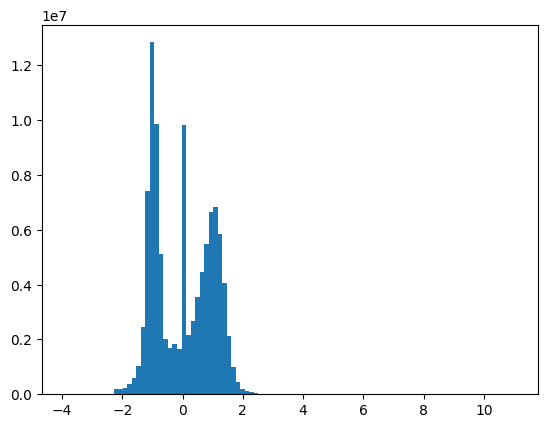

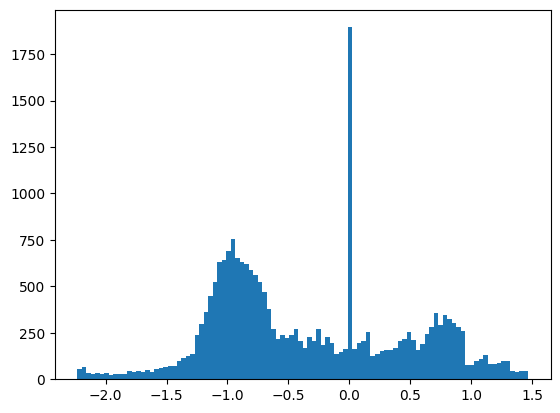

In [10]:
# np.sum(ppe_sim_train['vals'] > y_thresholds)
# test = np.log10(tgt_sim['vals'][0,7204:10804])
# test_finite = test[np.isfinite(test)]
a = 0
# ytrue = tgt_sim['vals'][:,a+6:a+3606]
# ytrue[~np.isfinite(ytrue)] = np.nan
# plt.hist(ytrue.flatten())
# plt.figure()
# plt.hist(y_all[:,5:65].flatten(), bins=100)
# plt.figure()
# plt.hist(tgt_all[:,5:65].flatten(), bins=100)

plt.hist(ppe_all[:,a+6:a+2580].flatten(), bins=100)
plt.figure()
plt.hist(tgt_all[:,a+6:a+2580].flatten(), bins=100)

In [11]:
# cc_model = tf.keras.models.load_model('condcoll_multioutput_try5_no_dropout.keras', compile=False)
cc_model = tf.keras.models.load_model('models/multioutput_try5_rainshaftdt300_M3069.keras', compile=False)


I0000 00:00:1747803845.298234  843881 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38366 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0


In [12]:
# REVIEW: check every time if this is true ... not sure how to implement this programatically
# param_table = pd.read_csv('/home/arthurhu/Cloud_BOSS/param_consolid_updated.csv')
param_table = pd.read_csv('/global/u2/a/arthurhu/Cloud_BOSS/param_consolid_RICO.csv')
param_names = param_table.columns[param_interest_idx + 1].to_list()
param_mean = param_table.values[0, param_interest_idx + 1].astype(np.float32)
param_std = param_table.values[1, param_interest_idx + 1].astype(np.float32)
# param_std[param_not_int_idx] = 0

## run

In [19]:
tfd = tfp.distributions

nchains = 8
# tf.keras.backend.set_floatx('float32')
IC_with_dummy = np.concatenate((tgt_sim_ics, np.zeros([n_tgt_ics, npar])), axis=1)
IC_norm = minmaxscale.transform(IC_with_dummy)[:,:n_init].astype('float32')
valid_mask = tf.math.is_finite(tgt_all)
weights = np.ones([n_tgt_ics, nobs]).astype('float32')

def target_log_prob_fn(params):
    params_2d = tf.tile(params[None, :], [n_tgt_ics,1]) # n_tgt_ics x npar

    param_lp = tf.reduce_sum(tfd.Uniform(low=tf.constant(0.0, dtype=tf.float32),
                                         high=tf.constant(1.0, dtype=tf.float32)).log_prob(params_2d))

    # get normalized ICs
    input_norm = tf.concat([IC_norm, params_2d], axis=1) # n_tgt_ics x n_input

    y_emu = cc_model(input_norm) # 2 * n_tgt_ics x nobs

    # emulated water presence
    y_emu_wpresence = tf.cast(y_emu[0], tf.float32)
    # FIXME: retrain the model usign logits to avoid arbitrary eps threshold
    eps = 1e-7
    y_emu_wpresence_clipped = tf.clip_by_value(y_emu_wpresence, eps, 1 - eps) # to avoid NaN in log likelihood
    valid_mask_float = tf.cast(valid_mask, tf.float32)
    wpresence_lps = tfp.distributions.Bernoulli(probs=y_emu_wpresence_clipped).log_prob(valid_mask_float)
    wpresence_lp = tf.reduce_sum(wpresence_lps)

    # emulated observed value
    y_emu_obs_norm = y_emu[1]
    y_emu_obs_norm_valid = tf.boolean_mask(y_emu_obs_norm, valid_mask)
    # y_emu_obs_norm_valid = tf.where(tf.math.is_nan(y_emu_obs_norm_valid), tf.constant(-20, dtype=y_emu_obs_norm_valid.dtype), y_emu_obs_norm_valid)
    tgt_all_valid = tf.boolean_mask(tgt_all, valid_mask)
    # weights_valid = tf.boolean_mask(weights, valid_mask)
    obs_lps = tfd.Normal(loc=tf.cast(y_emu_obs_norm_valid, tf.float32), scale=1.).log_prob(tf.cast(tgt_all_valid, tf.float32)) #*weights_valid
    obs_lp = tf.reduce_sum(obs_lps)

    return param_lp + wpresence_lp + obs_lp

batched_log_prob_fn = lambda params_batch: tf.vectorized_map(
    target_log_prob_fn, params_batch)

num_burnin_steps = 5000
num_samples = 10000
records = { 'step_size': [], 'log_acceptance_correction': [], 'num_leapfrog_steps': [] }

# 1) Base NUTS kernel
nuts_kernel = tfp.mcmc.NoUTurnSampler(
    target_log_prob_fn=batched_log_prob_fn,
    step_size=0.01,
    max_tree_depth=8
)

# 2) Wrap with DualAveragingStepSizeAdaptation for step-size tuning
nuts_kernel2 = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=nuts_kernel,
    num_adaptation_steps=int(num_burnin_steps * 0.8),  # e.g., adapt 80% of burn-in
    target_accept_prob=0.8
)

adaptive_nuts = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=nuts_kernel,
    num_adaptation_steps=num_burnin_steps,  # number of adaptation steps during burn-in
    target_accept_prob=0.8     # target acceptance probability
)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=batched_log_prob_fn,
        num_leapfrog_steps=3,
        step_size=0.1)
# adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
#     tfp.mcmc.HamiltonianMonteCarlo(
#         target_log_prob_fn=batched_log_prob_fn,
#         num_leapfrog_steps=3,
#         step_size=0.01),
#     num_adaptation_steps=int(num_burnin_steps * 0.8))

MALA_kernel = tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(
        target_log_prob_fn=batched_log_prob_fn,
        step_size=0.00001)

RWM_kernel = tfp.mcmc.RandomWalkMetropolis(
    target_log_prob_fn=batched_log_prob_fn,
    new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=0.00001)
)



@tf.function
def run_chain():
    initial_state = tf.zeros([nchains, npar], dtype='float32') + 0.5

    return tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        kernel=hmc,
        trace_fn=(lambda current_state, kernel_results: kernel_results),
        seed=42
    )

samples, kernel_results = run_chain()

In [25]:
# initial_state = tf.zeros([nchains, npar], dtype='float32') + 0.5
# print("Initial log probability:", batched_log_prob_fn(initial_state).numpy())
# try:
#     print("acceptance rate:", sum(kernel_results.is_accepted.numpy())/num_samples)
# except AttributeError:
#     print("acceptance rate:", sum(kernel_results.inner_results.is_accepted.numpy())/num_samples)

# kernel_results.new_step_size
initial_state = tf.zeros([nchains, npar], dtype='float32') + 0.5
lp0 = batched_log_prob_fn(initial_state).numpy()
lp1 = batched_log_prob_fn(initial_state + 1e-3).numpy()
print(lp0, lp1)

[-114900.1   -114900.086 -114900.086 -114900.086 -114900.1   -114900.086
 -114900.086 -114900.086] [-114540.75 -114540.75 -114540.75 -114540.75 -114540.75 -114540.75
 -114540.75 -114540.75]


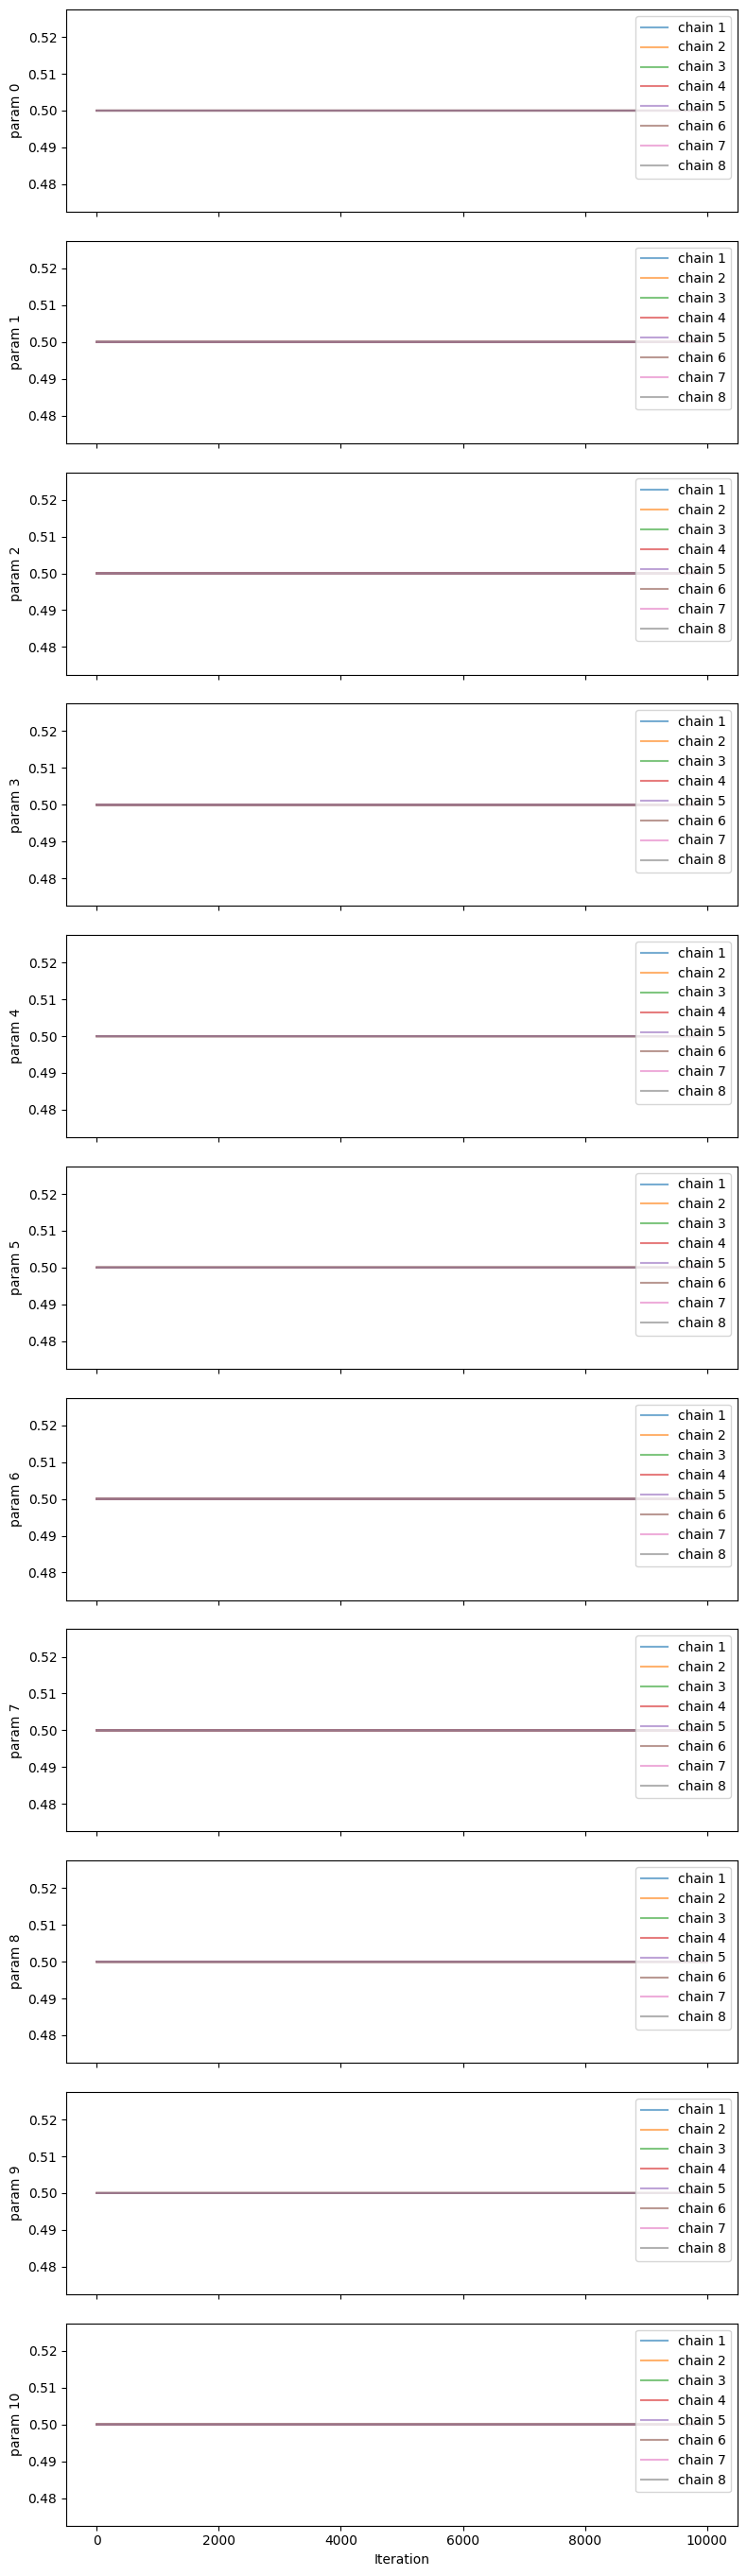

In [21]:
# --- 4. Trace plots ---
def plot_traces(posterior, title):
    its, chains, dims = posterior.shape
    fig, axes = plt.subplots(dims, 1, figsize=(8, 2.5*dims), sharex=True)
    for d in range(dims):
        for c in range(chains):
            axes[d].plot(posterior[:,c,d], alpha=0.6, label=f'chain {c+1}')
        axes[d].set_ylabel(f'param {d}')
        axes[d].legend(loc='upper right')
    axes[-1].set_xlabel('Iteration')
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_traces(samples, "")

In [22]:
tfp.mcmc.effective_sample_size(samples).numpy()

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
      dtype=float32)

In [23]:
tfp.mcmc.potential_scale_reduction(samples).numpy()

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
      dtype=float32)

In [96]:
params = tf.zeros(npar) + 0.5
params_2d = tf.tile(params[None, :], [n_tgt_ics,1]) # n_tgt_ics x npar
param_lp = tf.reduce_sum(tfd.Uniform(low=0.0,
                                     high=1.0).log_prob(params_2d))
input_norm = tf.concat([IC_norm, params_2d], axis=1) # n_tgt_ics x n_input
y_emu = cc_model(input_norm) # 2 * n_tgt_ics x nobs
obs_lps = tfd.Normal(loc=tf.cast(tgt_all, tf.float32), scale=1.).log_prob(tf.cast(y_emu[1], tf.float32))
print(tf.reduce_sum(obs_lps))

tf.Tensor(-30633.875, shape=(), dtype=float32)


In [108]:
import time

start = time.time()

def toy_lp(params):
    params_2d = tf.tile(params[None, :], [n_tgt_ics,1]) # n_tgt_ics x npar
    # param_lp = tf.reduce_sum(tfd.Uniform(low=tf.constant(0.0, dtype=tf.float32),
    #                                      high=tf.constant(1.0, dtype=tf.float32)).log_prob(params_2d))
    # get normalized ICs
    input_norm = tf.concat([IC_norm, params_2d], axis=1) # n_tgt_ics x n_input
    y_emu = cc_model(input_norm) # 2 * n_tgt_ics x nobs
    # emulated observed value
    y_emu_obs_norm = y_emu[1]
    y_emu_obs_norm_valid = tf.boolean_mask(y_emu_obs_norm, valid_mask)
    # y_emu_obs_norm_valid = tf.where(tf.math.is_nan(y_emu_obs_norm_valid), tf.constant(-20, dtype=y_emu_obs_norm_valid.dtype), y_emu_obs_norm_valid)
    tgt_all_valid = tf.boolean_mask(tgt_all, valid_mask)
    # weights_valid = tf.boolean_mask(weights, valid_mask)
    obs_lps = tfd.Normal(loc=tf.cast(tgt_all_valid, tf.float32), scale=1.).log_prob(tf.cast(y_emu_obs_norm_valid, tf.float32)) #*weights_valid
    obs_lp = tf.reduce_sum(obs_lps)
    return obs_lp

batched_toy_lp = lambda params_batch: tf.vectorized_map(
toy_lp, params_batch)

hmc = tfp.mcmc.HamiltonianMonteCarlo(batched_toy_lp, step_size=0.1, num_leapfrog_steps=3)
 
nuts = tfp.mcmc.NoUTurnSampler(
    target_log_prob_fn=batched_toy_lp,
    step_size=0.001,
    max_tree_depth=8
)

initial_state = tf.zeros([4, npar], dtype='float32') + 0.5
samples, kr = tfp.mcmc.sample_chain(num_results=100,
    current_state=initial_state,   # or your initial_state
    kernel=nuts,
    num_burnin_steps=50,
    seed=0)

end = time.time()
print(end-start)

/global/homes/a/arthurhu/.conda/envs/BOSS_PPE/lib/python3.12/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


2006.8602848052979


In [109]:
# def toy_lp(x): return tfd.Normal(0.,1.).log_prob(x)
# hmc = tfp.mcmc.HamiltonianMonteCarlo(toy_lp, step_size=0.1, num_leapfrog_steps=3)
# samples, _ = tfp.mcmc.sample_chain(num_results=500, current_state=0., kernel=hmc, num_burnin_steps=200, seed=0)
# plt.plot(samples.numpy())  # should look fuzzy, not flat
# tfd.Normal(0.,1.).log_prob(0)
# tfd.Uniform(low=0.0, high=1.0).log_prob(1.)
# plot_traces(samples, "")
samples, kr

(<tf.Tensor: shape=(100, 4, 11), dtype=float32, numpy=
 array([[[0.54463875, 0.57473135, 0.6750734 , ..., 0.47262684,
          0.5001426 , 0.4102834 ],
         [0.5209672 , 0.5488141 , 0.57054   , ..., 0.5226032 ,
          0.46648586, 0.47724703],
         [0.5301339 , 0.6292619 , 0.50584024, ..., 0.52335435,
          0.48783794, 0.4989194 ],
         [0.5005101 , 0.5660158 , 0.4719246 , ..., 0.50565666,
          0.517287  , 0.47985467]],
 
        [[0.5438829 , 0.5754984 , 0.67516017, ..., 0.47184536,
          0.49871686, 0.40919235],
         [0.524219  , 0.5431351 , 0.5923814 , ..., 0.5172001 ,
          0.46049622, 0.47154024],
         [0.5301339 , 0.6292619 , 0.50584024, ..., 0.52335435,
          0.48783794, 0.4989194 ],
         [0.5005101 , 0.5660158 , 0.4719246 , ..., 0.50565666,
          0.517287  , 0.47985467]],
 
        [[0.54407203, 0.57521755, 0.6779462 , ..., 0.47110835,
          0.49826705, 0.40850675],
         [0.5241308 , 0.5426349 , 0.5931764 , ..., 0.5177

# postprocessing

In [65]:
samples

<tf.Tensor: shape=(100, 11), dtype=float32, numpy=
array([[0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       ...,
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]], dtype=float32)>

In [ ]:
Na_norm = IC_norm[0,0].astype('float32')
Na_col = tf.fill([tf.shape(samples)[0], 1], Na_norm)
# w_norm = IC_norm[0,1].astype('float32')
# w_col = tf.fill([tf.shape(samples)[0], 1], w_norm)
samples_with_ic = tf.concat([Na_col, samples], axis=1)
samples_with_ic
samples_with_ic_raw_vals = minmaxscale.inverse_transform(samples_with_ic)
samples_raw_vals = samples_with_ic_raw_vals[:,n_init:]

In [ ]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(14,25))
gs = gridspec.GridSpec(10, 4)
for iparam, param_name in enumerate(param_names):
    ax = fig.add_subplot(gs[iparam])
    sns.kdeplot(samples_raw_vals[:,iparam], fill=True)
    plt.title(param_name)
    # plt.plot((param_mean[iparam], param_mean[iparam]), ax.get_ylim(), color='tab:red')

plt.show()


##  save distribution for PPE

In [ ]:
nbins = 50
count = {}
bins = {}
# count = np.zeros([nbins, npar])
# bins = np.zeros([nbins + 1, npar])
for iparam, param_name in enumerate(param_names):
    count[param_name], bins[param_name] = np.histogram(samples_raw_vals[:, iparam], bins=nbins)
    count[param_name] = count[param_name]/np.sum(count[param_name])

In [ ]:
samples_raw_vals.shape

In [ ]:
pd.DataFrame.from_dict(count).to_csv('MCMC_posterior/' + case_name + '_r0_param_density_RWM.csv', index=False)
pd.DataFrame.from_dict(bins).to_csv('MCMC_posterior/' + case_name + '_r0_param_bins_RWM.csv', index=False)

In [31]:
case_name

'rainshaftdt300'

## update params csv

In [32]:
original_params = pd.read_csv('/global/u2/a/arthurhu/Cloud_BOSS/param_consolid_RICO.csv')
updated_params = original_params.copy()
for iparam, param_name in enumerate(param_names):
    binmean = (bins[param_name][1:] + bins[param_name][:-1])/2
    weighted_mean = np.average(binmean, weights=count[param_name])
    updated_params.loc[0, param_name] = weighted_mean

# coal_density = pd.read_csv('MCMC_posterior/coal_r2_param_density.csv')
# coal_param_names = coal_density.keys()[1:].to_list()
# coal_bin_edges = pd.read_csv('MCMC_posterior/coal_r2_param_bins.csv')

# for iparam, param_name in enumerate(coal_param_names):
#     binmean = (coal_bin_edges[param_name][1:].to_numpy() + coal_bin_edges[param_name][:-1].to_numpy())/2
#     weighted_mean = np.average(binmean, weights=coal_density[param_name])
#     updated_params.loc[0, param_name] = weighted_mean

updated_params.to_csv('/global/u2/a/arthurhu/Cloud_BOSS/param_consolid_RWM.csv', index=False)

## validation

In [40]:
IC_norm

array([[0.02167574, 0.02168023],
       [0.02167574, 0.13038467],
       [0.02167574, 0.34779352],
       [0.02167574, 0.78261125],
       [0.13038498, 0.02168023],
       [0.13038498, 0.13038467],
       [0.13038498, 0.34779352],
       [0.13038498, 0.78261125],
       [0.34780347, 0.02168023],
       [0.34780347, 0.13038467],
       [0.34780347, 0.34779352],
       [0.34780347, 0.78261125],
       [0.78264046, 0.02168023],
       [0.78264046, 0.13038467],
       [0.78264046, 0.34779352],
       [0.78264046, 0.78261125]], dtype=float32)

In [54]:
meanresult = np.mean(samples, axis=0)
meanresult = tf.expand_dims(meanresult, axis=0)
meanresult_tiled = tf.tile(meanresult, [16, 1])
meanresults_incl_ics = tf.concat([IC_norm, meanresult_tiled], axis=1)
vars_after_MCMC_norm = cc_model(meanresults_incl_ics)


In [42]:
y_predict = vars_after_MCMC_norm[1][valid_mask]
y_true = tgt_all[valid_mask]

In [56]:
vars_after_MCMC_norm[1].shape

TensorShape([16, 14404])

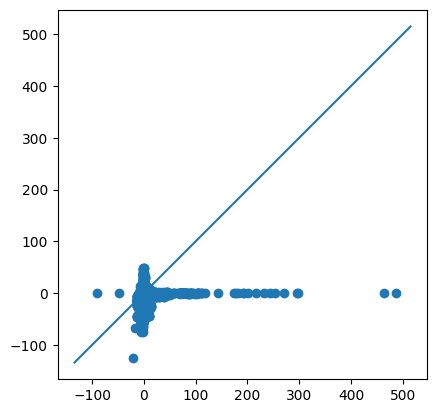

In [46]:
plt.scatter(y_true, y_predict)
ax = plt.gca()
ax.set_aspect('equal')
ax_min = min(list(ax.get_ylim() + ax.get_xlim()))
ax_max = max(list(ax.get_ylim() + ax.get_xlim()))
plt.plot([ax_min, ax_max], [ax_min, ax_max])
# plt.xscale('log')
# plt.yscale('log')
